In [45]:
import requests
import rasterio
from shapely.geometry import mapping
from rasterio.features import geometry_mask
import numpy as np
import matplotlib.pyplot as plt

# PDOK API Base URL


# Define bounding box (Amersfoort RD New coordinates - EPSG:28992)
bbox = "94500,469500,95000,470000"  # xmin, ymin, xmax, ymax
crs = "http://www.opengis.net/def/crs/EPSG/0/28992"
item_type = "waterdeel_vlak"

def get_top10nl(bbox, crs, item_type):
    BASE_URL = "https://api.pdok.nl/brt/top10nl/ogc/v1"
    # API Request URL
    url = f"{BASE_URL}/collections/{item_type}/items?bbox={bbox}&bbox-crs={crs}&crs={crs}&limit=1000&f=json"
    
    # Send GET request
    response = requests.get(url)
    
    # Check response
    if response.status_code == 200:
       data = response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
    return data
    

In [30]:
waterdata = get_top10nl(bbox, crs, "waterdeel_vlak")

In [31]:
wegdata = get_top10nl(bbox, crs, "wegdeel_vlak")

In [32]:
terreindata = get_top10nl(bbox, crs, "terrein_vlak")

In [39]:
tifpath = "output/final_dtm.tif"

In [53]:
with rasterio.open(tifpath) as dst:
    array = dst.read(1)

In [ ]:
# Roofs              2
# Dark_asphalt       1 
# Cobble_stone_2014a 0  
# Water              7  
# Grass_unmanaged    5   
# bare_soil          6   

In [42]:
def load_buildings(buildings_path, layer):
    """
    Load in the building shapes from a geopackage file.
    ----
    Input:
    - buildings_path (string):   path to the geopackage file.
    - layer (string):            (Tile) name of the layer of buildings to be used

    Output:
    - List of dictionaries: A list of dictionaries containing:
      - "geometry": building geometry in GeoJSON-like format.
      - "parcel_id": corresponding parcel ID.
    """
    buildings_gdf = gpd.read_file(buildings_path, layer=layer)

    if 'identificatie' not in buildings_gdf.columns:
        raise ValueError("Column 'identificatie' not found in the dataset")

    return [{"geometry": mapping(geom), "parcel_id": identificatie} for geom, identificatie in zip(buildings_gdf.geometry, buildings_gdf["identificatie"])]

In [43]:
buildingdata = load_buildings("output/buildtest.gpkg", "test")

In [62]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def visualize_raster(raster_array):
    # Define discrete colors for each category
    cmap = ListedColormap(["gray", "blue", "black", "green", "brown", "yellow", "tan", "cyan"])  
    categories = [-9999, 0, 1, 2, 3, 4, 5, 6, 7]  # Define unique values in the raster
    
    norm = BoundaryNorm(categories, cmap.N)  # Ensures discrete mapping

    plt.figure(figsize=(6, 6))
    img = plt.imshow(raster_array, cmap=cmap, norm=norm, interpolation='nearest')
    
    # Define color bar with correct tick positions
    cbar = plt.colorbar(img, ticks=categories)
    cbar.set_label("Land Cover Type")
    
    plt.title("Discrete Raster Visualization")
    plt.show()

In [55]:
print(waterdata)

{'type': 'FeatureCollection', 'timeStamp': '2025-02-14T13:59:05Z', 'links': [{'rel': 'self', 'title': 'This document as GeoJSON', 'type': 'application/geo+json', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/waterdeel_vlak/items?bbox=94500%2C469500%2C95000%2C470000&bbox-crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&f=json&limit=1000'}, {'rel': 'alternate', 'title': 'This document as JSON-FG', 'type': 'application/vnd.ogc.fg+json', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/waterdeel_vlak/items?bbox=94500%2C469500%2C95000%2C470000&bbox-crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&f=jsonfg&limit=1000'}, {'rel': 'alternate', 'title': 'This document as HTML', 'type': 'text/html', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/waterdeel_vlak/items?bbox=94500%2C469500%2C95000%2C470000&b

In [63]:
def convert_to_raster(array, water, road, terrain, buildings, transform):
    array.fill(-9999)
    building_geometries = [shape(building['geometry']) for building in buildings]
    print(array.shape)
    building_mask = geometry_mask(building_geometries, transform=transform, invert=False, out_shape=array.shape)

    

    # Apply the mask to the filled DTM
    new_array = np.where((building_mask), array, 2)
    
    features = water.get("features", [])
    water_geometries = [shape(wat['geometry']) for wat in features]
    water_mask = geometry_mask(water_geometries, transform=transform, invert=False, out_shape=array.shape)
    
    new_array = np.where((water_mask), new_array, 7)
    
    visualize_raster(new_array)
    return new_array
    
    

(998, 998)


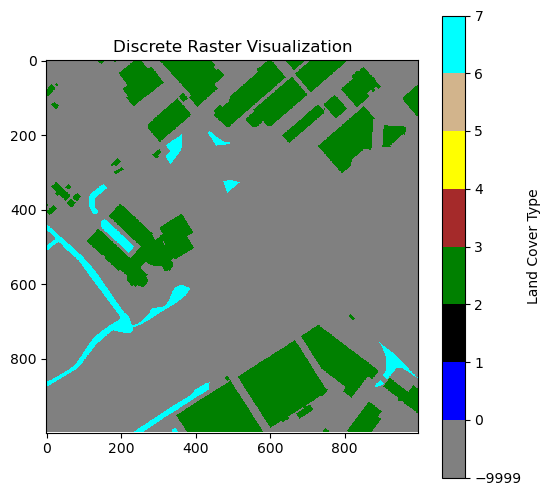

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [64]:
convert_to_raster(array, waterdata, wegdata, terreindata, buildingdata, dst.transform)


In [4]:
from pyproj import Transformer

# RD New (EPSG:28992) bounding box
xmin, ymin, xmax, ymax = 94500, 469500, 95000, 470000

# Define transformer from EPSG:28992 (RD New) to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:28992", "EPSG:4326", always_xy=True)

# Convert coordinates
lon_min, lat_min = transformer.transform(xmin, ymin)
lon_max, lat_max = transformer.transform(xmax, ymax)

# Print transformed bounding box in CRS84
bbox_crs84 = f"{lon_min},{lat_min},{lon_max},{lat_max}"
print("Bounding Box in CRS84:", bbox_crs84)

Bounding Box in CRS84: 4.5020341162919655,52.2102765212564,4.509260209662704,52.214824618486595


In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape

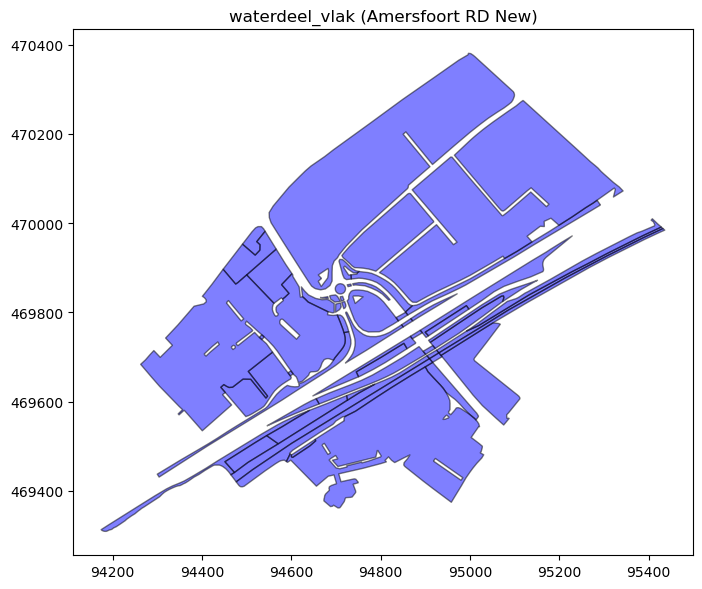

In [34]:
features = terreindata.get("features", [])

if features:
    # Extract geometries
    geometries = [shape(feature["geometry"]) for feature in features]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:28992")

    # Plot data
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)
    ax.set_title(f"{item_type} (Amersfoort RD New)")
    plt.show()
    
    output_file = "terrein_vlak.geojson"
    gdf.to_file(output_file, driver="GeoJSON")

In [35]:
print(terreindata)

{'type': 'FeatureCollection', 'timeStamp': '2025-02-14T14:00:06Z', 'links': [{'rel': 'self', 'title': 'This document as GeoJSON', 'type': 'application/geo+json', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/terrein_vlak/items?bbox=94500%2C469500%2C95000%2C470000&bbox-crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&f=json&limit=1000'}, {'rel': 'alternate', 'title': 'This document as JSON-FG', 'type': 'application/vnd.ogc.fg+json', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/terrein_vlak/items?bbox=94500%2C469500%2C95000%2C470000&bbox-crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&crs=http%3A%2F%2Fwww.opengis.net%2Fdef%2Fcrs%2FEPSG%2F0%2F28992&f=jsonfg&limit=1000'}, {'rel': 'alternate', 'title': 'This document as HTML', 'type': 'text/html', 'href': 'https://api.pdok.nl/brt/top10nl/ogc/v1/collections/terrein_vlak/items?bbox=94500%2C469500%2C95000%2C470000&bbox-cr